# Credit Approval Machine Learning Project

## Introduction
This project is on credit card application approvals and the goal of the project is to train a model to correctly predict the outcome of the credit card applications. There are a variety of features and the outcome (target) is a positive (approved) or negative (declined) credit card application. A supervised learning algorithim will be used since there are labels for the data. This is a classification problem since the outcome is positive or negative. 

## The Data
The dataset was retrieved from UCI Machine Learning Repository (Quinlan, https://doi.org/10.24432/C5FS30).

The data is tabular (rows and columns of data) and comes from the one data source. There are 15 features (columns), and 690 samples (rows). Of the 15 features, 6 are numerical and 9 are categorical. The target variable is binary.  

The feature names were changed to meaningless numbers and the categorical variable values were changed to meaningless letters to protect confidentiality.

## Data Cleaning
The raw data has some inconsistences that need to be addressed before moving forward. First, the target variable has values of "+" and "-" for positive and negative. To convert this to a more typical form for a binary target variable, "+" will be changed to 1, and "-" will be changed to 0. Second, there are some missing values in the data set. We will need to identify the missing values and then decide what to do with them: either drop the column, or the row, or impute. 


In [2]:
#import all necessary libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pylab as plt 
import seaborn as sns
%matplotlib inline 

In [3]:
#load in data
ccdata = pd.read_csv('crx.csv', header = None)
print(ccdata.head())
print(ccdata.info())
ccdata.describe(include = 'all')

  0      1      2  3  4  5  6     7  8  9   10 11 12   13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g   43  560  +
2  a   24.5  0.500  u  g  q  h  1.50  t  f   0  f  g  280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  120    0  +
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 n

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,690,690,690.000000,690,690,690,690,690.000000,690,690,690.00000,690,690,690,690.000000,690
unique,3,350,NaN,4,4,15,10,NaN,2,2,NaN,2,3,171,NaN,2
top,b,?,NaN,u,g,c,v,NaN,t,f,NaN,f,g,0,NaN,-
freq,468,12,NaN,519,519,137,399,NaN,361,395,NaN,374,625,132,NaN,383
mean,NaN,NaN,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,NaN,1017.385507,NaN
std,NaN,NaN,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,NaN,5210.102598,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,NaN,5.000000,NaN
75%,NaN,NaN,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,NaN,395.500000,NaN


From the above type and description information, we can see a few errors. Column 1 and 13 are numerical columns, but the type is shown as object. This is most likely because a string is inputted in the place of missing or null values. So we will look into those 2 columns, and all the other columns to see if there are any other null/missing values: 

In [4]:
#find the rows that have missing data in all columns

#common ways to have missing/null values in dataset
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?', '.','', ' ', '   ']

#initialize variables to hold infromation
#dictionary to hold count for number of times a row has missing data
row_freq_dict = {}
#array of columns that have missing data, for later use
columns_with_missing = []
#dictionary of missing rows with column as key
missing_rows_per_column_dict = {}

#go through all columns checking for missing values
for c in ccdata.columns:
    #find any value in column that is in a
    string_undefined = [ind for ind, x in enumerate(ccdata[c]) if x in a]
    
    #if len of list is > 0, then there are missing values and need to fix
    if len(string_undefined) > 0:
        #add c to columns_with_missing
        columns_with_missing.append(c)
        #add rows to dictionary for missing rows with the column number as key
        missing_rows_per_column_dict[c] = string_undefined
        #go through each element to count how many times each row doeasn't have data
        for ele in string_undefined: 
            if ele not in row_freq_dict:
                row_freq_dict[ele] = 1
            else:
                row_freq_dict[ele] += 1
    #print each column, the number of missing values, and the rows that have missing
    #values in that column
    print(c, len(string_undefined), string_undefined) 

#We will delete row if it has data missing from more than 4 columns
#create list of rows to delete
rows_to_delete = [row for row in row_freq_dict if row_freq_dict[row] > 4]
rows_to_delete
#print(columns_with_missing)
#print(missing_rows_per_column_dict)


0 12 [248, 327, 346, 374, 453, 479, 489, 520, 598, 601, 641, 673]
1 12 [83, 86, 92, 97, 254, 286, 329, 445, 450, 500, 515, 608]
2 0 []
3 6 [206, 270, 330, 456, 592, 622]
4 6 [206, 270, 330, 456, 592, 622]
5 9 [206, 270, 330, 456, 479, 539, 592, 601, 622]
6 9 [206, 270, 330, 456, 479, 539, 592, 601, 622]
7 0 []
8 0 []
9 0 []
10 0 []
11 0 []
12 0 []
13 13 [71, 202, 206, 243, 270, 278, 330, 406, 445, 456, 592, 622, 626]
14 0 []
15 0 []


[206, 270, 330, 456, 592, 622]

From the above, we can see that 7 columns have null/missing values! Column 13 has the most missing data, but still only has 13 missing values (which is ~2% of the total data). Since there is no column that has a large portion (>5%) of missing data, we will keep all the columns. This means we need to either impute all the missing data, or drop rows that have missing data. 
We will drop any row that has more than 4 columns without data. With all the other missing values, we will impute with the mode for categorical variables or the median for numerical variables. 

Before doing that, we will change all the missing data points to Python recognized nulls. Then we will impute the values, and lastly drop the necessary rows. 

In [5]:
#go through all columns that have missing data
#replace all string nulls with None
for c in columns_with_missing:
    ccdata.loc[missing_rows_per_column_dict[c], c] = None

In [6]:
#change columns 1 and 13 to float
for c in [1,13]:
    ccdata[c] = pd.to_numeric(ccdata[c])
print(ccdata.info())
ccdata.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    object 
 1   1       678 non-null    float64
 2   2       690 non-null    float64
 3   3       684 non-null    object 
 4   4       684 non-null    object 
 5   5       681 non-null    object 
 6   6       681 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      677 non-null    float64
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB
None


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,678,678.000000,690.000000,684,684,681,681,690.000000,690,690,690.00000,690,690,677.000000,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,NaN,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,NaN,NaN,-
freq,468,NaN,NaN,519,519,137,399,NaN,361,395,NaN,374,625,NaN,NaN,383
mean,NaN,31.568171,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,184.014771,1017.385507,NaN
std,NaN,11.957862,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,173.806768,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,22.602500,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,75.000000,0.000000,NaN
50%,NaN,28.460000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,160.000000,5.000000,NaN
75%,NaN,38.230000,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,276.000000,395.500000,NaN


In [7]:
#impute columns with median for numerical column and mode for categorical column
for c in columns_with_missing:
    if ccdata[c].dtype == 'object':
        ccdata[c].fillna(ccdata[c].mode()[0], inplace = True)
    else:
        ccdata[c].fillna(ccdata[c].median(), inplace = True)
ccdata.describe(include = 'all')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,690,690.000000,690.000000,690,690,690,690,690.000000,690,690,690.00000,690,690,690.000000,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,NaN,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,NaN,NaN,-
freq,480,NaN,NaN,525,525,146,408,NaN,361,395,NaN,374,625,NaN,NaN,383
mean,NaN,31.514116,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,183.562319,1017.385507,NaN
std,NaN,11.860245,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,172.190278,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,22.670000,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,80.000000,0.000000,NaN
50%,NaN,28.460000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,160.000000,5.000000,NaN
75%,NaN,37.707500,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,272.000000,395.500000,NaN


In [8]:
#change "+" to 1 and "-" to 0 for target column (column 15)
ccdata[15] = [1 if ele == "+" else 0 for ele in ccdata[15]]

In [9]:
#drop the rows with >4 columns missing data
print(ccdata.shape)
print(len(rows_to_delete))
ccdata = ccdata.drop(rows_to_delete, axis = 0)
ccdata.reset_index(drop=True, inplace=True)
ccdata.shape

(690, 16)
6


(684, 16)

In [10]:
#look at the summary after cleaning
ccdata.describe(include = 'all')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,684,684.000000,684.000000,684,684,684,684,684.000000,684,684,684.000000,684,684,684.000000,684.000000,684.000000
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,NaN,NaN,NaN
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,NaN,NaN,NaN
freq,476,NaN,NaN,519,519,140,402,NaN,361,389,NaN,368,625,NaN,NaN,NaN
mean,NaN,31.479284,4.800468,NaN,NaN,NaN,NaN,2.242909,NaN,NaN,2.421053,NaN,NaN,183.769006,1026.309942,0.442982
std,NaN,11.796111,4.979873,NaN,NaN,NaN,NaN,3.354657,NaN,NaN,4.879025,NaN,NaN,172.930726,5232.060836,0.497102
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,22.670000,1.030000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.000000,NaN,NaN,79.000000,0.000000,0.000000
50%,NaN,28.460000,2.855000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,160.000000,5.000000,0.000000
75%,NaN,37.750000,7.500000,NaN,NaN,NaN,NaN,2.720000,NaN,NaN,3.000000,NaN,NaN,272.500000,400.000000,1.000000


In [11]:
ccdata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,0
680,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,0
681,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,0
682,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,0


## Data Cleaning Summary
The raw data was not in bad shape, but there were a few things that needed to be corrected before moving on to analysis and modeling. Two columns had type object when they should have had a numerical type. This was found to be caused by missing data that was inputted with a '?'. All columns were checked for null or missing values. 7 columns had missing values. These columns were all kept because the missing values represented <2% of each column. However, there were a few rows that had multiple missing data points. The decision was made to drop any row that had more than 4 columns of missing data. The remaining missing data was imputed with the median for numerical columns or the mode for categorical columns. The columns with type object, that were really numerical, were converted to numerical type. The target variable was also converted, from having "+" and "-" categories to 1 and 0, respectively. 
 

## Exploratory Data Analysis


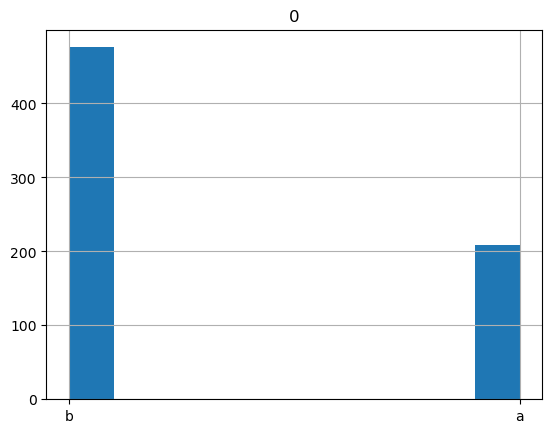

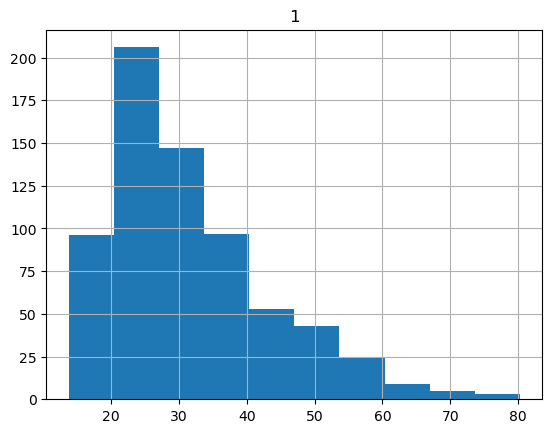

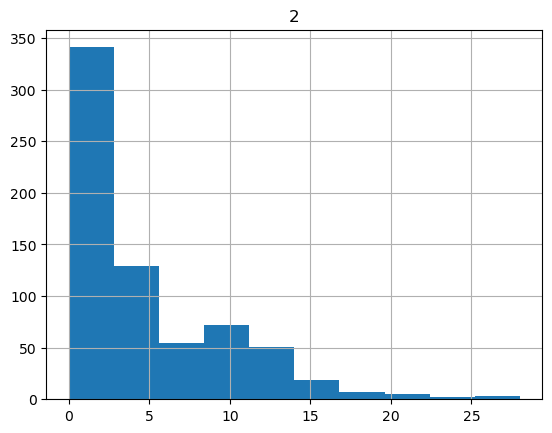

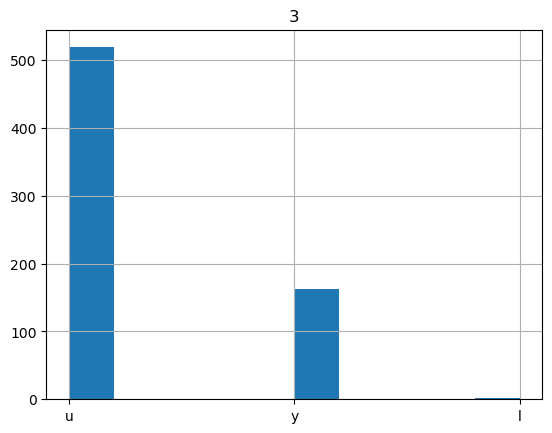

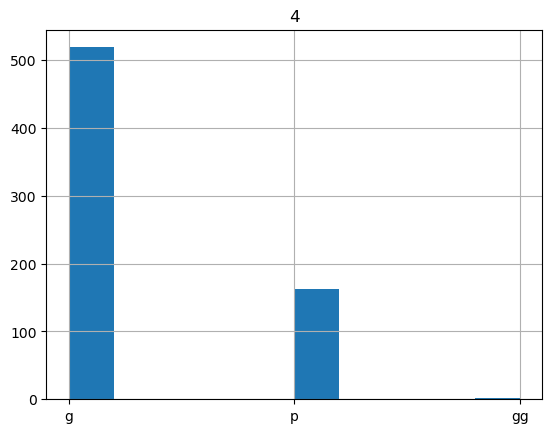

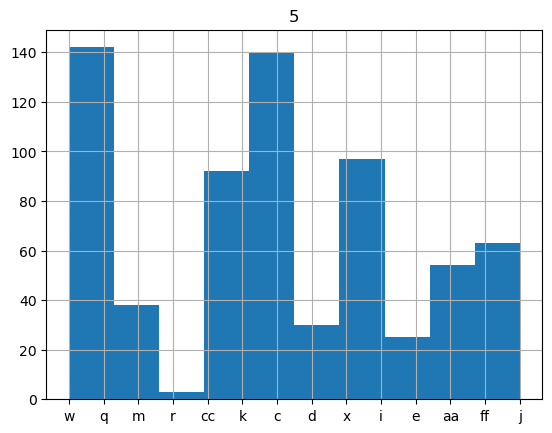

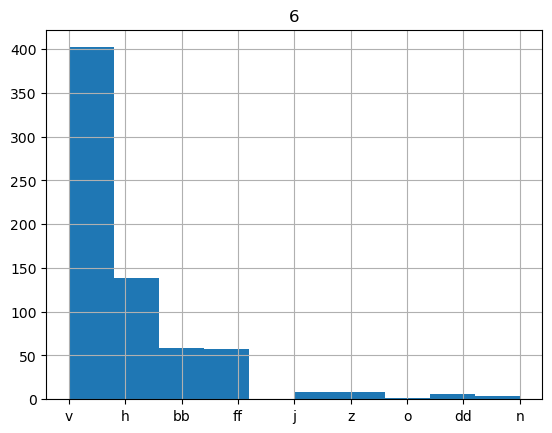

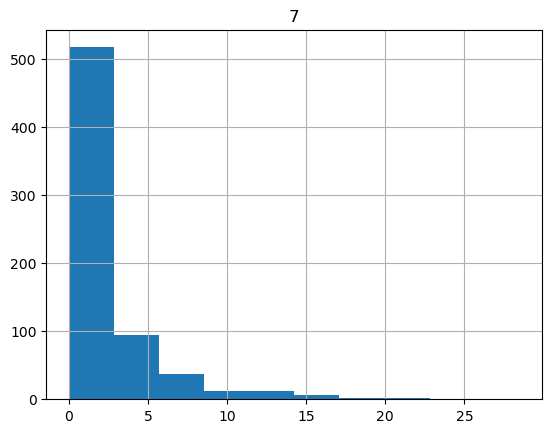

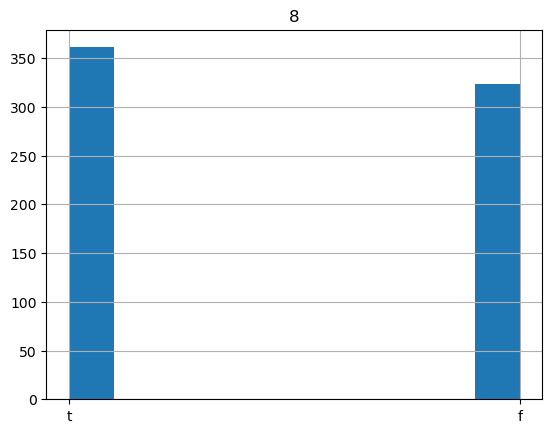

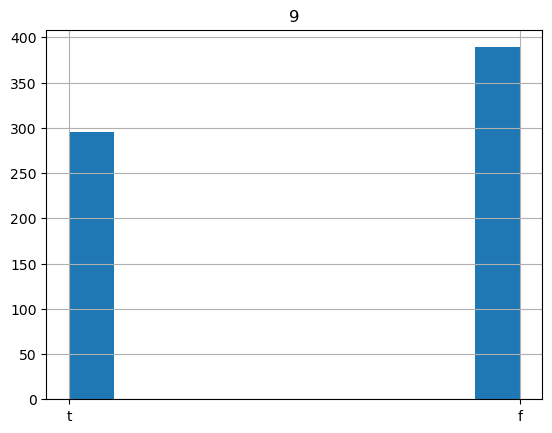

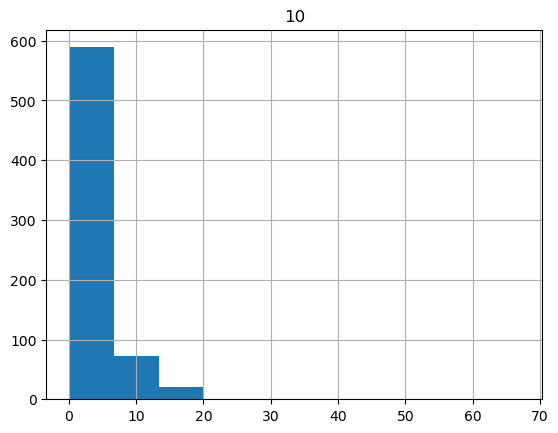

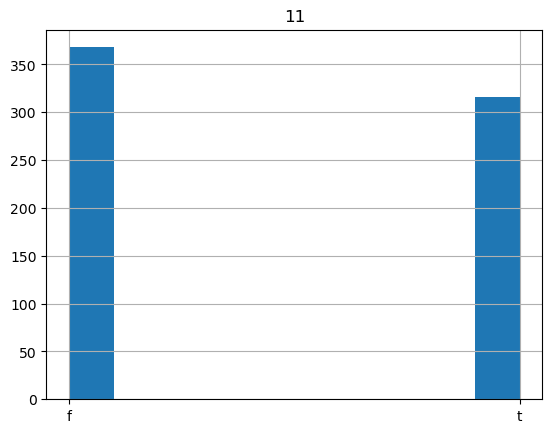

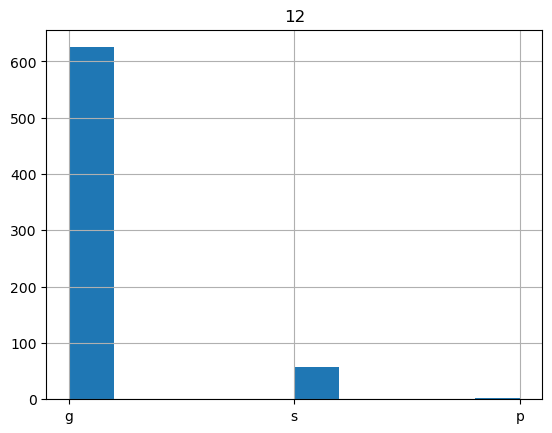

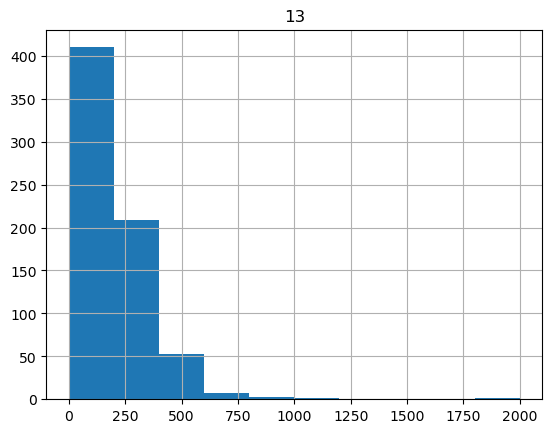

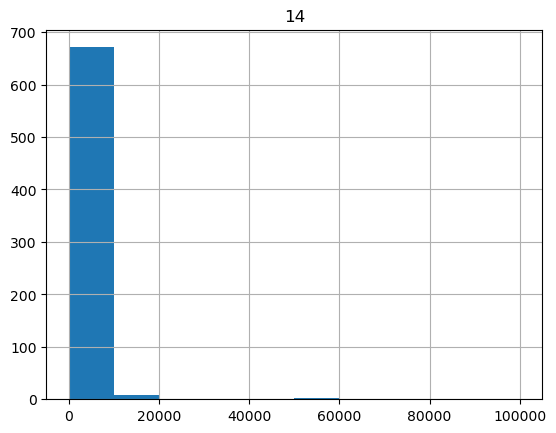

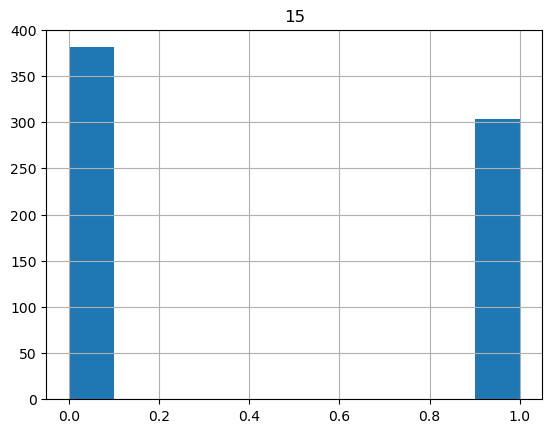

In [12]:
#create histograms for numerical columns
for c in ccdata.columns:
    ccdata[c].hist()
    plt.title(c)
    plt.show()

Histograms of each column were made, and there were no obvious signs of problems. The categorical variables have some imbalances, and the numerical variables are all right-skewed, but they don't seem implausible for the type of data. Feature 1 is slightly right-skewed, while the rest of the numerical features are very right-skewed. 

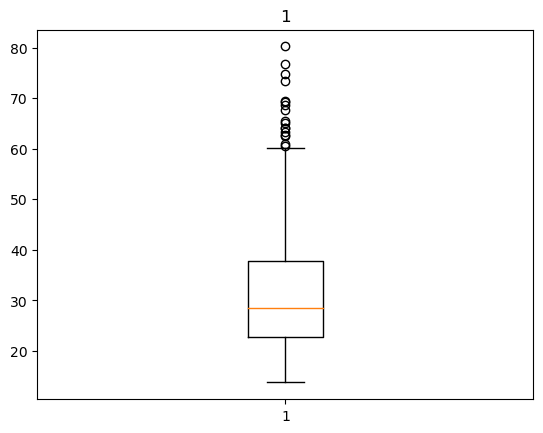

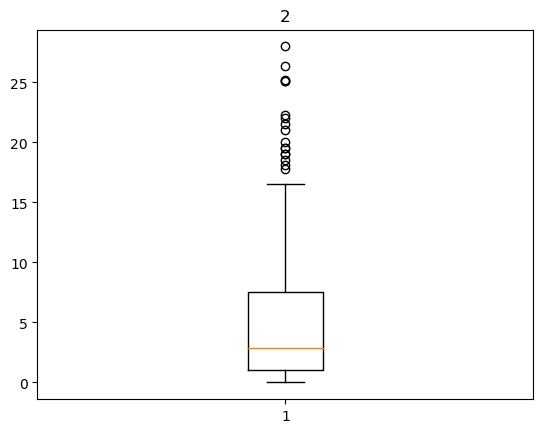

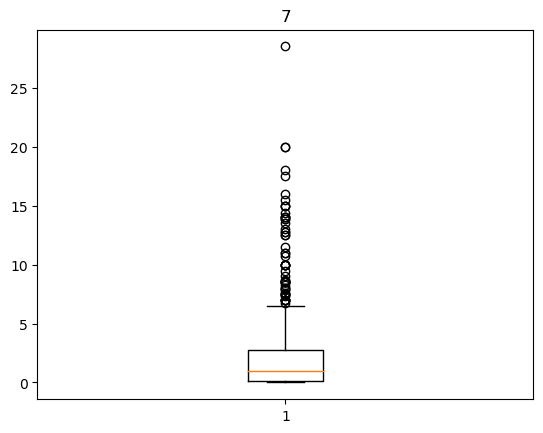

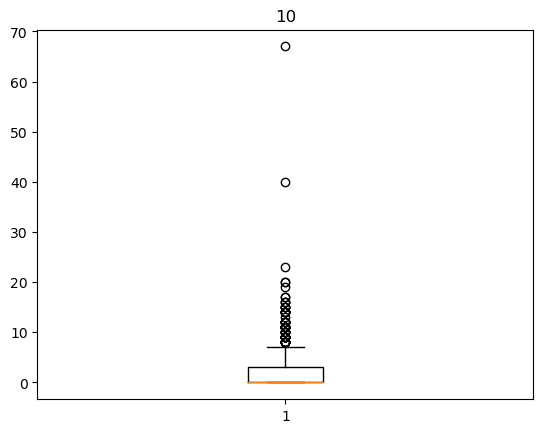

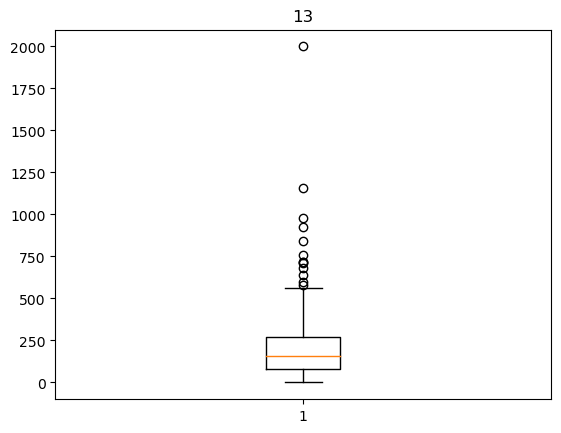

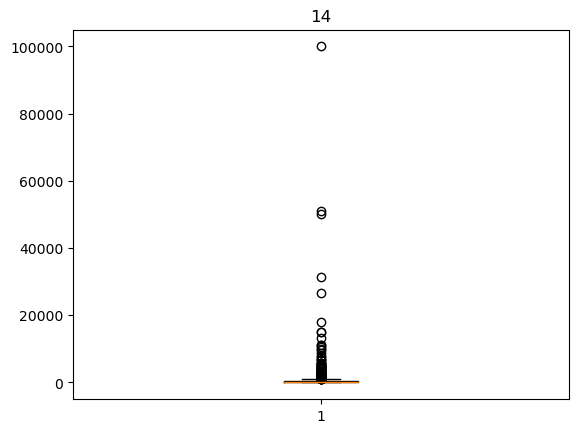

In [13]:
#create boxplots for numerical columns
for c in ccdata.columns[0:15]:
    if not ccdata[c].dtype == 'object':
        plt.boxplot(ccdata[c])
        plt.title(c)
        plt.show()

The boxplots show many potential outliers, but most seem somewhat reasonable. The one feature's boxplot that seems abnormal is feature 14. The boxplot itself is very small with a lot of potential outlier points shown on the plot. Feature's 14 data is very right-skewed and has some points that are much larger than the median of the dataset. We will still plan to use feature 14 and will check the models to see if it is adding value. 

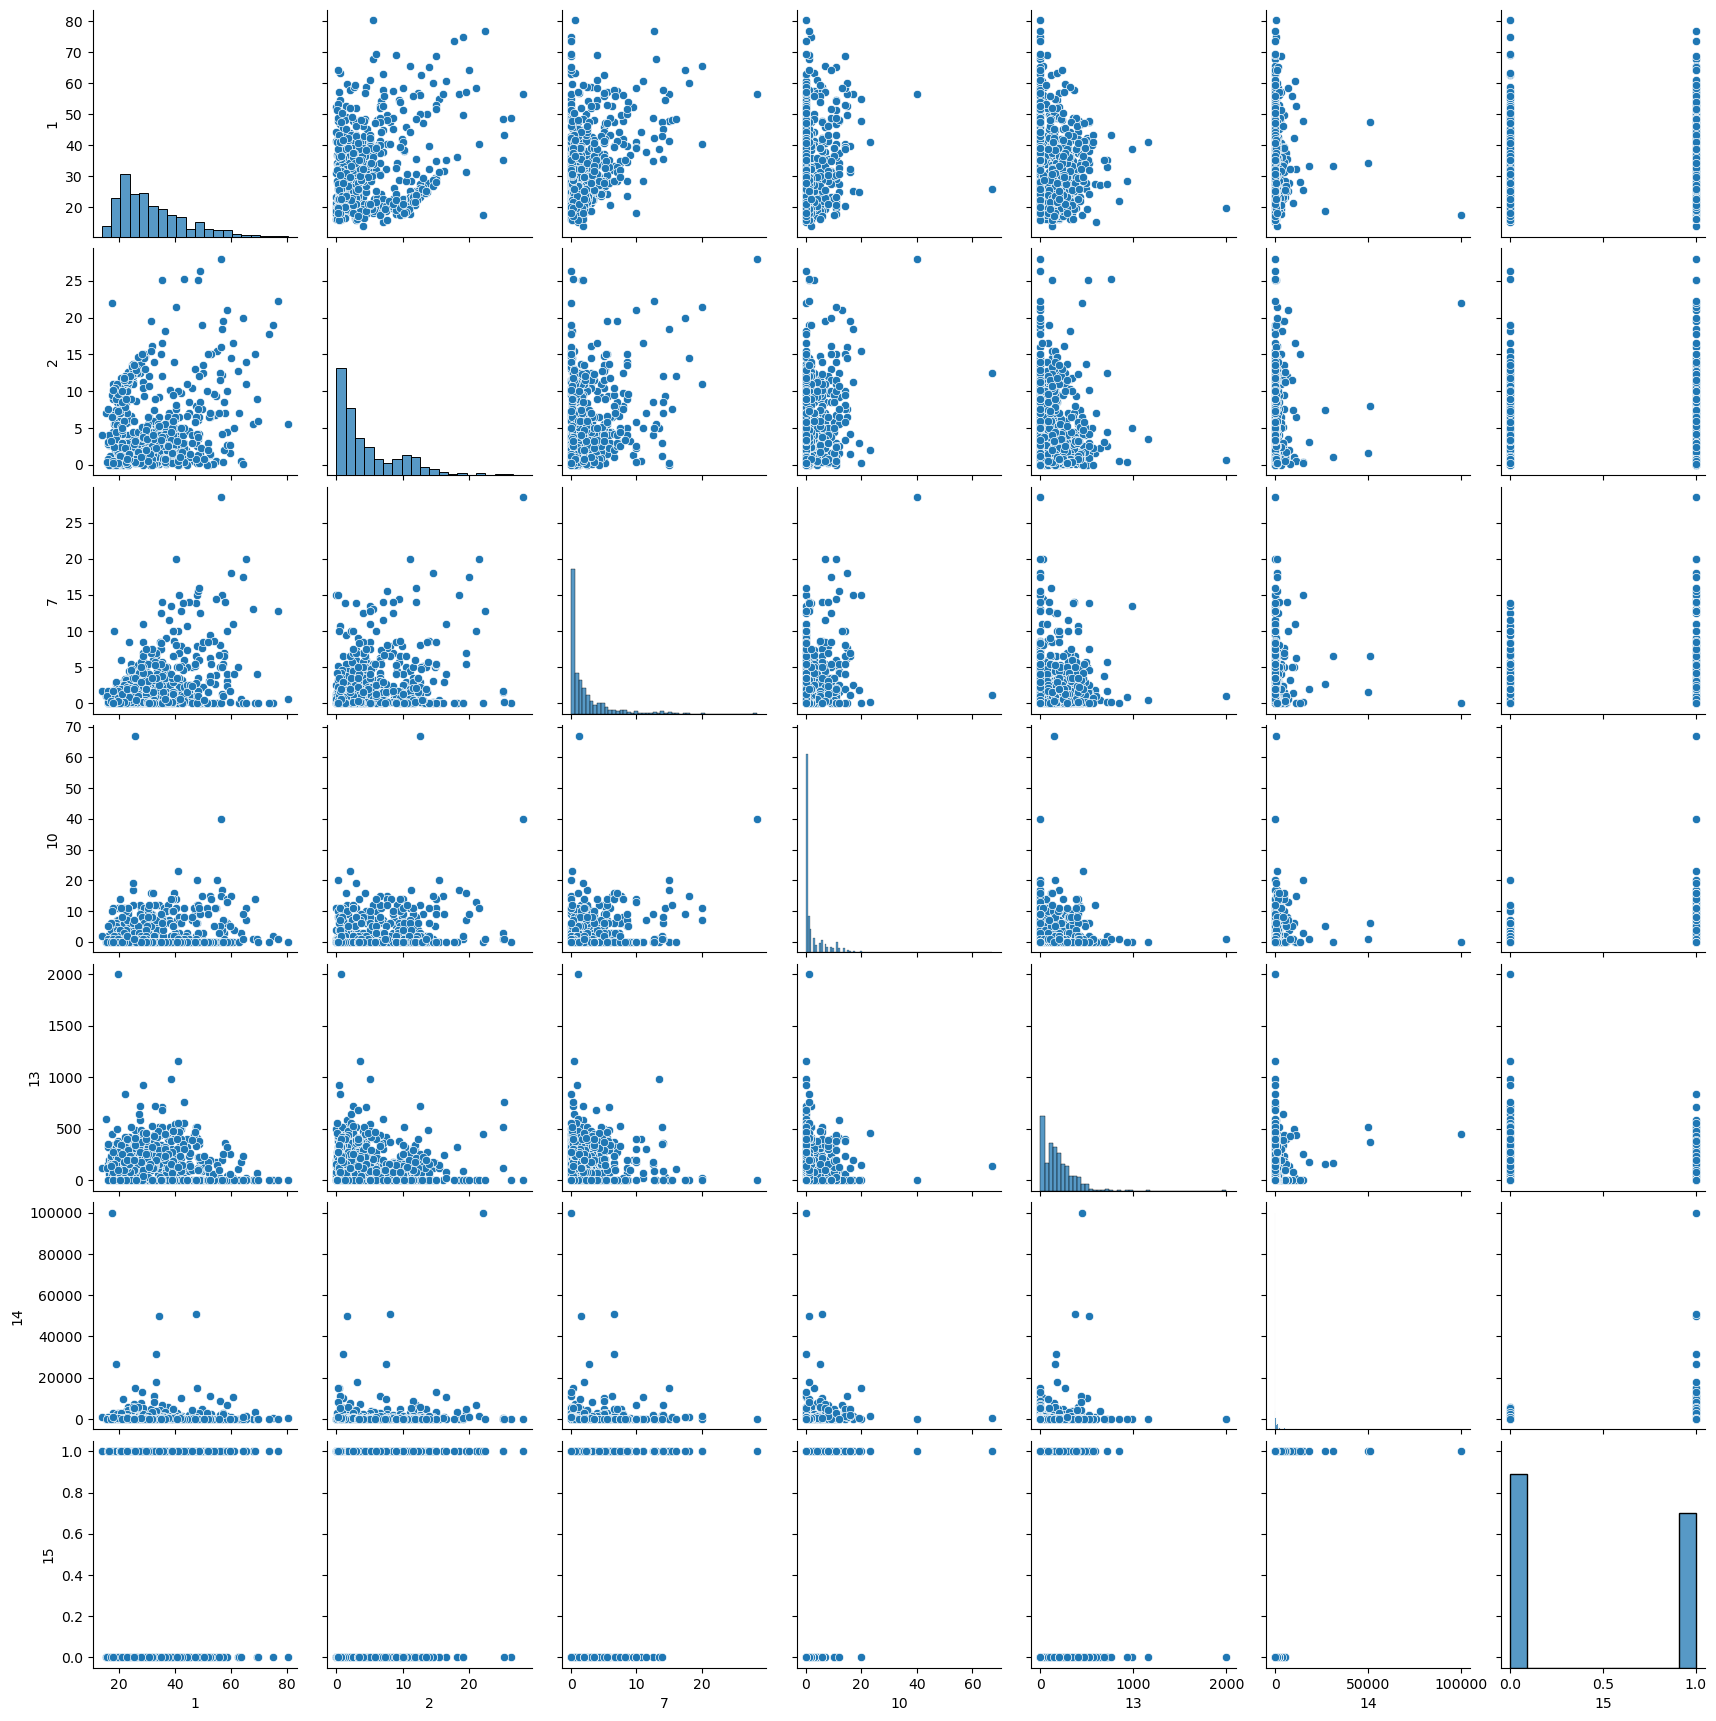

In [14]:
#create pairplot
sns.pairplot(ccdata)

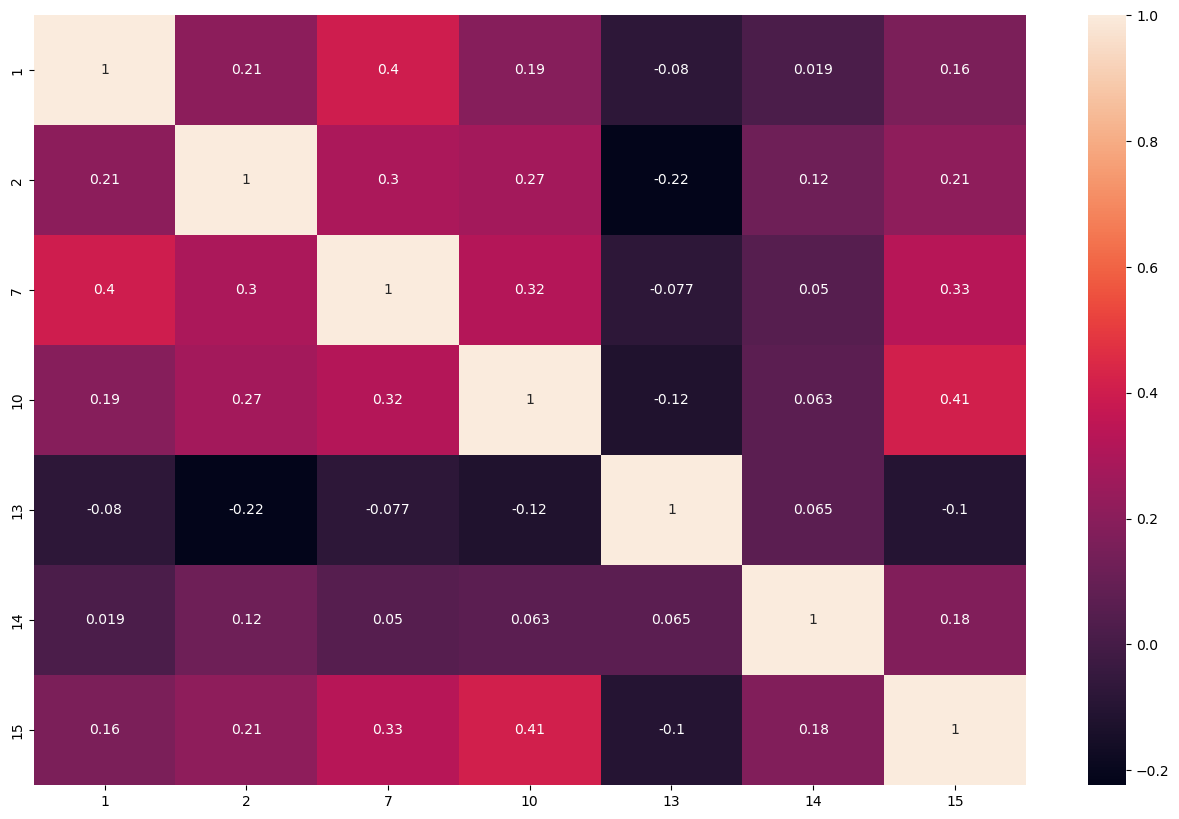

In [15]:
#create correlation matrix
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
corr_matrix = ccdata.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot=True)
plt.show()

The pair plot and correlation matrix show that there are no strongly correlated variables. Correlations range between -0.22 to 0.41, with The highest correlation being between feature 10 and 15 (the target variable). Most of the correlations are very weak and could lead to a poor performing model. However, the hope will be that using all the features (along with the categorical features) will lead to good results with the classfication model. 

## Models

In [16]:
#split dataframe to X and y variables
X = ccdata.loc[:,0:14]
y = ccdata.loc[:,15]

In [17]:
#make variable with numerical columns and variable for categorical variables for encoding
num_cols = [1,2,7,10,13,14]
cat_cols = [0,3,4,5,6,8,9,11,12]
x_num = X[num_cols]
x_cat = X[cat_cols]

#make encoder for categorical and transform
ohe_enc = OneHotEncoder(sparse_output = False).fit_transform(x_cat)

#get column names for the encoded columns
dumm = pd.get_dummies(x_cat)
ohe_column_names = dumm.columns.to_list()

#set encoded matrix to dataframe with column names
x_cat_ohe = pd.DataFrame(ohe_enc, columns = ohe_column_names)
#print(x_cat_ohe)

In [18]:
#Scale the numerical columns and set to dataframe
scl = StandardScaler()
x_num_scl = scl.fit_transform(x_num)
x_num_scl_df = pd.DataFrame(x_num_scl, columns = num_cols)
x_num_scl_df.columns = x_num_scl_df.columns.astype(str)

#join the categorical and numerical columns back to one df
x_trf = pd.concat([x_num_scl_df, x_cat_ohe], axis = 1)
x_trf

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,6_z,8_f,8_t,9_f,9_t,11_f,11_t,12_g,12_p,12_s
0,-0.055082,-0.964679,-0.296196,-0.291471,0.105501,-0.196301,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,2.306744,-0.068419,0.237781,0.734074,-0.814615,-0.089191,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,-0.592093,-0.864202,-0.221618,-0.496580,0.556879,-0.038696,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.309590,-0.655208,0.449582,0.528965,-0.484762,-0.195728,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,-0.959431,0.165694,-0.158973,-0.496580,-0.369024,-0.196301,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,-0.882231,1.061955,-0.296196,-0.496580,0.441141,-0.196301,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
680,-0.747342,-0.813963,-0.072463,-0.086362,0.093927,-0.120941,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
681,-0.528466,1.748217,-0.072463,-0.291471,0.093927,-0.196110,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
682,-1.150312,-0.923484,-0.657153,-0.496580,0.556879,-0.052850,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [19]:
#split to test and training sets
X_train, X_test, y_train, y_test = train_test_split(x_trf, y, test_size = 0.2, random_state = 658)

#create variables to hold classifier type and metric scores for all models trialed
#will use these to show results in table in results section
mod = []
mod_train_acc = []
mod_test_acc = []
mod_recall = []
mod_precision = []
mod_f1 = []

In [22]:
#make logisitc regression classifier
lrclf = LogisticRegression()

#fit ligistic regression classifier and check accuracy of train data
lrclf.fit(X_train, y_train)
print(lrclf.score(X_train,y_train))

#check accuracy of test data
print(lrclf.score(X_test,y_test))

0.8756855575868373
0.8978102189781022


In [23]:
#make predictioins with the test set
yp = lrclf.predict(X_test)

#calculate more metrics
#add results to lists
mod.append("Logistic Regression")
mod_train_acc.append(lrclf.score(X_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

accuracy: 0.8978102189781022
recall:  0.9516129032258065
precision:  0.8428571428571429
F1:  0.8939393939393939


,0,1
0,64,11
1,3,59


In [24]:
#Make SVM classifier model
#Do cross-validation on various kernel, C, and gamma paramter values
svm = SVC()

#set parameter values to trial
kernel = ['linear','poly','rbf','sigmoid']
C = np.logspace(-5, 5, 11, base=2)
gamma = np.logspace(-5, 5, 11, base=2)
parameters = {'C': C, 'gamma' : gamma, 'kernel' : kernel}

#do gridsearch
grid = GridSearchCV(svm, parameters)
grid.fit(X_train, y_train)

#print best combination and cv accuracy
print("The best combination of parameters is: " + str(grid.best_params_))
print("The cross-validation accuracy achieved with these parameters is: " + str(grid.best_score_))

The best combination of parameters is: {'C': 0.25, 'gamma': 0.03125, 'kernel': 'sigmoid'}
The cross-validation accuracy achieved with these parameters is: 0.8646371976647206


In [25]:
#calculate training accuracy
print('Training accuracy: ', grid.score(X_train,y_train))

#check more metrics
yp = grid.predict(X_test)

#calculate more metrics
#add results to lists
mod.append("SVC")
mod_train_acc.append(grid.score(X_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('Test accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

Training accuracy:  0.8555758683729433
Test accuracy: 0.8905109489051095
recall:  0.967741935483871
precision:  0.821917808219178
F1:  0.8888888888888888


,0,1
0,62,13
1,2,60


In [26]:
#make gradient boosting classifier
#Do cross-validation on various paramter values
gbclf = GradientBoostingClassifier()

#set parameter values to trial
max_features = ['sqrt', None]
max_depth = [2,4,8,16,32]
min_samples_leaf = [1,4,8,16,32]
learning_rate = [0.01,0.1,1]
n_estimators = [10, 100, 1000]
parameters = {'max_features': max_features, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf,
             'learning_rate':learning_rate} #,'n_estimators' : n_estimators}

#do gridsearch
grid = GridSearchCV(gbclf, parameters, verbose = 1)
grid.fit(X_train, y_train)

#print best combination and cv accuracy
print("The best combination of parameters is: " + str(grid.best_params_))
print("The cross-validation accuracy achieved with these parameters is: " + str(grid.best_score_))


Fitting 5 folds for each of 150 candidates, totalling 750 fits
The best combination of parameters is: {'learning_rate': 0.01, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4}
The cross-validation accuracy achieved with these parameters is: 0.873861551292744


In [27]:
print('Training accuracy: ', grid.score(X_train,y_train))

#check more metrics
yp = grid.predict(X_test)
yp_forplotting = yp

#calculate more metrics
#add results to lists
mod.append("Gradient Boosting")
mod_train_acc.append(grid.score(X_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('Test accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

Training accuracy:  0.9524680073126143
Test accuracy: 0.927007299270073
recall:  0.9032258064516129
precision:  0.9333333333333333
F1:  0.9180327868852459


,0,1
0,71,4
1,6,56


In [28]:
#make random forest classifier
#Do cross-validation on various paramter values
rfclf = RandomForestClassifier()

#set parameter values to trial
max_features = ['sqrt', None]
max_depth = [4,8,16,32, None]
min_samples_leaf = [1,4,8,16,32]
#n_estimators = [10, 100, 1000]
parameters = {'max_features': max_features, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf}
             #'n_estimators': n_estimators}
    
#do gridsearch
grid = GridSearchCV(rfclf, parameters, verbose = 1)
grid.fit(X_train, y_train)

#print best combination and cv accuracy
print("The best combination of parameters is: " + str(grid.best_params_))
print("The cross-validation accuracy achieved with these parameters is: " + str(grid.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best combination of parameters is: {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 16}
The cross-validation accuracy achieved with these parameters is: 0.8719933277731442


In [29]:
print('Training accuracy: ', grid.score(X_train,y_train))

#check more metrics
yp = grid.predict(X_test)

#calculate more metrics
#add results to lists
mod.append("Random Forest")
mod_train_acc.append(grid.score(X_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('Test accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

Training accuracy:  0.8829981718464351
Test accuracy: 0.8905109489051095
recall:  0.9193548387096774
precision:  0.8507462686567164
F1:  0.883720930232558


,0,1
0,65,10
1,5,57


In [30]:
#get variable importance
feature_list = list(x_trf.columns)
# Get numerical feature importances
bestrfclf = grid.best_estimator_
importances = list(bestrfclf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#put 0.0 importance variables in variable to delete
columns_to_delete = [ele[0] for ele in feature_importances if ele[1] < 0.005]

Variable: 8_t                  Importance: 0.47
Variable: 8_f                  Importance: 0.3
Variable: 14                   Importance: 0.09
Variable: 13                   Importance: 0.05
Variable: 2                    Importance: 0.03
Variable: 1                    Importance: 0.01
Variable: 7                    Importance: 0.01
Variable: 10                   Importance: 0.01
Variable: 9_f                  Importance: 0.01
Variable: 9_t                  Importance: 0.01
Variable: 0_a                  Importance: 0.0
Variable: 0_b                  Importance: 0.0
Variable: 3_l                  Importance: 0.0
Variable: 3_u                  Importance: 0.0
Variable: 3_y                  Importance: 0.0
Variable: 4_g                  Importance: 0.0
Variable: 4_gg                 Importance: 0.0
Variable: 4_p                  Importance: 0.0
Variable: 5_aa                 Importance: 0.0
Variable: 5_c                  Importance: 0.0
Variable: 5_cc                 Importance: 0.0
Vari

In [31]:
#Drop <0.01 importantance variables (according to rf)
x_sm_train = X_train.drop(columns=columns_to_delete) 
x_sm_test = X_test.drop(columns=columns_to_delete) 

In [32]:
#Make another random forest classifier on the smaller data set
#Do cross-validation again on dataset with nonimportant columns removed
rfclf = RandomForestClassifier()

#set parameter values to trial
max_features = ['sqrt', None]
max_depth = [4,8,16,32, None]
min_samples_leaf = [1,4,8,16,32]
#n_estimators = [10, 100, 1000]
parameters = {'max_features': max_features, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf}
             #'n_estimators': n_estimators}

#do gridsearch
grid = GridSearchCV(rfclf, parameters, verbose = 1)
grid.fit(x_sm_train, y_train)

#print best combination and cv accuracy
print("The best combination of parameters is: " + str(grid.best_params_))
print("The cross-validation accuracy achieved with these parameters is: " + str(grid.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best combination of parameters is: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1}
The cross-validation accuracy achieved with these parameters is: 0.8756463719766472


In [33]:
print('Training accuracy: ', grid.score(x_sm_train,y_train))

#check more metrics
yp = grid.predict(x_sm_test)

#calculate more metrics
#add results to lists
mod.append("Random Forest - Deleted columns")
mod_train_acc.append(grid.score(x_sm_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('Test accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

Training accuracy:  0.8903107861060329
Test accuracy: 0.8905109489051095
recall:  0.9193548387096774
precision:  0.8507462686567164
F1:  0.883720930232558


,0,1
0,65,10
1,5,57


In [34]:
#make another gradient boosting classifier on smaller data set
#Do cross-validation again on dataset with nonimportant columns removed
gbclf = GradientBoostingClassifier()

#set parameter values to trial
max_features = ['sqrt', None]
max_depth = [2,4,8,16,32]
min_samples_leaf = [1,4,8,16,32]
learning_rate = [0.01,0.1,1]
n_estimators = [10, 100, 1000]
parameters = {'max_features': max_features, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf,
             'learning_rate':learning_rate} #,'n_estimators' : n_estimators}

#do gridsearch
grid = GridSearchCV(gbclf, parameters, verbose = 1)
grid.fit(x_sm_train, y_train)

#print best combination and cv accuracy
print("The best combination of parameters is: " + str(grid.best_params_))
print("The cross-validation accuracy achieved with these parameters is: " + str(grid.best_score_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
The best combination of parameters is: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4}
The cross-validation accuracy achieved with these parameters is: 0.8774979149291076


In [35]:
print('Training accuracy: ', grid.score(x_sm_train,y_train))

#check more metrics
yp = grid.predict(x_sm_test)

#calculate more metrics
#add results to lists
mod.append("Gradient Boosting - Deleted Columns")
mod_train_acc.append(grid.score(x_sm_train,y_train))
mod_test_acc.append(accuracy_score(y_test,yp))
mod_recall.append(recall_score(y_test,yp))
mod_precision.append(precision_score(y_test,yp))
mod_f1.append(f1_score(y_test,yp))

#print results
print('Test accuracy:', accuracy_score(y_test,yp))
print('recall: ', recall_score(y_test,yp))
print('precision: ', precision_score(y_test,yp))
print('F1: ', f1_score(y_test,yp))
pd.DataFrame(confusion_matrix(y_test,yp, labels=[0,1]))

Training accuracy:  0.8939670932358318
Test accuracy: 0.8905109489051095
recall:  0.8548387096774194
precision:  0.8983050847457628
F1:  0.8760330578512397


,0,1
0,69,6
1,9,53


## Results

The results from all models can be seen in the table below. The models used were logistic regression (LR), support vector classifier (SVC), gradient boosting (GB), and random forest (RF). Logistic regression was fitted first with all default values for the parametes. There are no hyperparameters for logistic regression, so no tuning was done, but regularization is applied by default with the L2 penalty term. 

The support vector classifier, gradient boosting, and random forest models all have hyperparameters. A cross-validation grid search was used on each model to tune the hyperparameters and choose the best values. The support vector classifier cross-validation grid search used different values for the kernel, C, and gamma parameters. The gradient boosting cross-validation grid search used different values for the max_features, max_depth, min_samples_leaf, and learning_rate parameters. The random forest cross-validation grid search used different values for the max_features, max_depth, and min_samples_leaf parameters.

For each different model, the best parameters from the grid search were chosen and then used to predict the test data. 

In [36]:
#Make table of all the metric results for the different models
results = pd.DataFrame(list(zip(mod, mod_train_acc,mod_test_acc,mod_recall,mod_precision,mod_f1)), 
                       columns = ['Model', 'Train Accuracy', 'Test Accuracy', 'Recall', 'Precision', 'F1'])
results

,Model,Train Accuracy,Test Accuracy,Recall,Precision,F1
0,Logistic Regression,0.875686,0.897810,0.951613,0.842857,0.893939
1,SVC,0.855576,0.890511,0.967742,0.821918,0.888889
2,Gradient Boosting,0.952468,0.927007,0.903226,0.933333,0.918033
3,Random Forest,0.882998,0.890511,0.919355,0.850746,0.883721
4,Random Forest - Deleted columns,0.890311,0.890511,0.919355,0.850746,0.883721
5,Gradient Boosting - Deleted Columns,0.893967,0.890511,0.854839,0.898305,0.876033


All the models performed similarly. The test accuracies ranged from 0.89 to 0.93, and the F1 scores ranged from 0.88 to 0.92. The best performing model was the gradient boosting model according to test accuracy, precision, and F1 score. However, since it was only slightly better than the logisitic regression model, an argument could be made to choose the logistic regression model. This is because of Occam's razor, which suggests that if you have similar results between models, you should go with the simpler one. 

Most of the models have more false positives (predicted positive, when actually negative) than false negatives (predicted negative, when actually positive). If it was known which error was worse (for this specific situation and use case), this could  lead to choosing a different model. If recall was determined to be the most important metric, then the support vector classifier would be the best performing model. 

The random forest model has a built-in attribute called feature importance. This shows that most of the variables are not important. Only 10 variables have an importance greater than 0, while 36 have an importance of 0.0. The training and test sets were modified by dropping all the columns that had an importance of 0.0. Additional random forest and gradient boosting models were fitted to this smaller set of data to see if there was much impact. These are the last two models shown in the table above. 

These models performed similarly to the original models and were only slightly worse. If resources and time were contraints in the situation, then these models would be great options, since they have much fewer features.

In [37]:
#make one dataframe to use seaborn to plot 
df = pd.concat([X_test,y_test], axis = 1)
#reset index
df.reset_index(drop=True, inplace=True)
#concat y predicted to df
df = pd.concat([df,pd.Series(yp)], axis =1)
#rename y values to something useful
df = df.rename(columns={15: 'y_actual', 0: 'y_pred'})

In [38]:
def CalculatePerformance(row):
    """This function calculates if samples prediction is 
    true positive, true negative, false postive, or false negative
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function

    """
    yp = row['y_pred']
    ya = row['y_actual']
    
    if ya == 0:
        if yp == 0:
            ypt = ("tn")
        else:
            ypt = ("fp")
    else:
        if yp == 1:
            ypt = ("tp")
        else: 
            ypt = ("fn")
    
    return ypt

In [39]:
df['Performance'] = df.apply(CalculatePerformance, axis = 1)
df

,1,2,7,10,13,14,0_a,0_b,3_l,3_u,...,9_f,9_t,11_f,11_t,12_g,12_p,12_s,y_actual,y_pred,Performance
0,-0.698137,1.572381,-0.631796,-0.086362,-1.063452,0.865625,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,tn
1,-0.804182,-0.805925,-0.582575,-0.291471,1.367044,-0.142172,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,tn
2,-0.479261,1.614582,-0.519929,-0.496580,-1.063452,-0.195919,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,tn
3,1.684050,1.044873,-0.669085,1.759619,-1.063452,0.042594,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,1,tp
4,-0.853387,-0.813963,-0.445352,-0.496580,-0.299582,-0.195919,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,tn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2.129438,2.752993,3.805583,2.990273,-1.063452,-0.196301,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,1,tp
133,-1.504077,-0.160858,-0.147040,-0.086362,-0.369024,-0.005032,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,1,tp
134,0.022966,-0.361814,-0.669085,-0.496580,-0.137549,-0.192476,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,tn
135,1.380338,0.642963,1.680116,0.734074,-1.063452,0.044698,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,1,tp


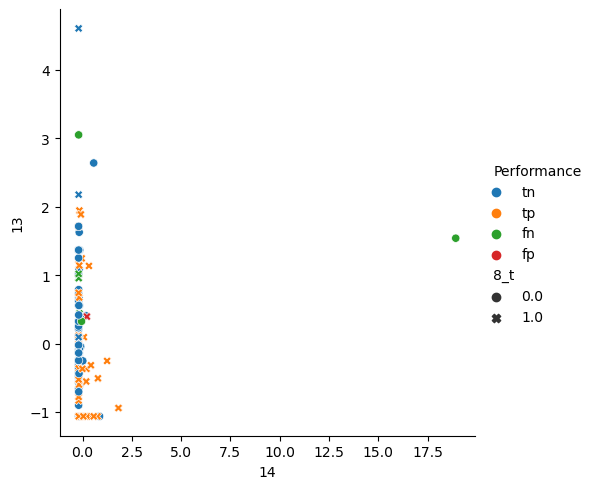

In [42]:
g = sns.relplot(data=df, x="14", y="13", hue = 'Performance', style = "8_t")

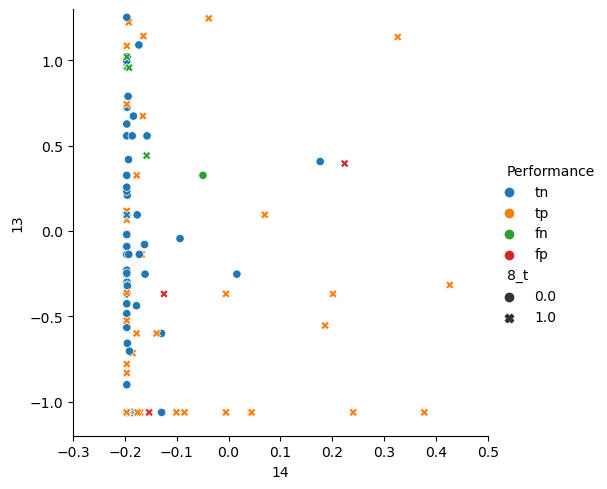

In [45]:
g = sns.relplot(data=df, x="14", y="13", hue = 'Performance', style = "8_t")
g.set(xlim=(-0.3,0.5),ylim=(-1.2,1.3))

The plots above use feature 14 as the x variable, feature 13 as the y variable, feature 8_t to determine the shape, and the performance as the color. These plots show that the variable column 8 (which includes 8_t and 8_f in the dataset) are critical to the predictions made in our model. Most samples with 8_t of 1 are predicted as positive (1) and most with 8_t of 0 are predicted as negative (0). This agrees with the random forest model feature importance, which has 8_t and 8_f combining for a 0.77 importance!

The second plot is the same as the first plot but limited to just the bottom left region of the first plot. This area is where most of the prediction errors are. You can scan over the plot and see where the errors occur. The colors green (false negative), and red (false positive) are the errors. It seems like the true positives are mostly toward the bottom and right, while the true negatives are mostly toward the left. However, feature 8 still has a huge impact on the outcome.

## Conclusion

The best performing model was the gradient boosting model with learning_rate as 0.01, max_depth as 16, max_features as 'sqrt',  and 'min_samples_leaf' as 4. This model had an accuracy of 0.93, and F1 score of .92. The other models were not much worse with accuracies around 0.89 and F1 scores around 0.88. The only metric that didn't show gradient boosting as the best model was recall, as it showed the support vector classifier as the best.

One of the most important steps of any data science project is extracting and cleaning the data. If you don't have good or clean data, then you will not get good, reliable results. This project was a great learning oppurtunity because at a quick glance, the data looked okay. There were no defined "null" values in the data set. However, after digging deeper, there were a couple numerical columns that were showing as object columns and this was the first clue that there was most likely missing data that were encoded with some type of string. The missing data in this dataset was shown by a "?". There were 7 columns that had missing values, but no column had a large portion of data missing. The decision was made to impute the missing data with the mode for categorical variables or the median for numerical variables. One way to potentially improve the models would be to improve the dataset by having a better way to impute the missing data. This may require specific domain knowledge on the application to know the best way to impute this specific dataset.

## References

Quinlan,Quinlan. Credit Approval. UCI Machine Learning Repository. https://doi.org/10.24432/C5FS30.